*Project for the course in Microeconometrics, Summer 2019, Bonn University*

---

## Replication of Jason M. Lindo, Nicholas J. Sanders & Philip Oreopoulos (2010) <a class="tocSkip"> 

In this notebook I replicate the main results from 

_Lindo, J. M., Sanders, N. J., & Oreopoulos, P. (2010). Ability, gender, and performance standards: Evidence from academic probation. American Economic Journal: Applied Economics, 2(2), 95-117._


The paper as well as all the materials needed for the replication can be accessed [here](https://www.aeaweb.org/articles?id=10.1257/app.2.2.95).

---

In [76]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas.io.formats.style
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm_api
import matplotlib as plt
from IPython.display import HTML


# Overview 

Lindo et al. (2010) examine the effects of academic probation on student outcomes using data from Canada. Academic probation is a university policy that aims to improve the performance of the lowest scoring students. If a student's grade point average (GPA) drops below a certain threshold, the student is placed on academic probabtion. The probation status serves as a warning and does not entail immediate consequences, however, if students fail to improve their grades during the following year, they face the threat of being suspended from university. In a more general sense, academic probation may offer insights into how agents respond to negative incentives and the threat of punishment in a real world context with high stakes. 

To estimate the causal impact of being placed on probation, Lindo et al. (2010) apply a **regression discontinuity design (RDD)** to data retrieved from three campuses at a large Canadian university. The RDD is motivated by the idea that the students who score just above the threshold for being put on academic probation provide a good counterfactual to the 'treatment group' that scores just below the threshold and is put on academic probation. 

**Observed outcomes:**
* Drop-out rates
* Subsequent performance
* Graduation rates

**Covariates:**
* Gender
* High school performance
* Native language 
* Age at entry
* Credits attempted in 1st year
* Birthplace
* Campus

# Causal Graphs

wip

# Study replication

In [77]:
# Loading the data
data = pd.read_stata('data/data_for_analysis.dta')
data.shape

(44362, 86)

## Data & Descriptive Statistics
Overview of all variables in the provided dataset:

In [78]:
columnlist = data.columns
print(columnlist)

Index(['credits1', 'credits2', 'credits_earned1', 'credits_earned2',
       'session1', 'winter_ac_standing', 'GPA_year1', 'GPA_year2',
       'CGPA_year1', 'CGPA_year2', 'totcredits_year1', 'totcredits_year2',
       'goodstanding_year1', 'goodstanding_year2', 'winter_ac_stand_year1',
       'winter_ac_stand_year2', 'fallreg_year1', 'fallreg_year2',
       'act_fallreg_year1', 'act_fallreg_year2', 'summerreg_year1',
       'summerreg_year2', 'sex', 'mtongue', 'identifier', 'age_at_entry',
       'bpl_north_america', 'bpl_asia', 'canadian', 'bpl_other', 'firstyear',
       'yearstodegree', 'gradin4', 'gradin5', 'gradin6', 'gradin4orcont',
       'cumcredits1', 'cumcredits2', 'prog_science', 'prog_socsci_bus',
       'prog_socscihum', 'prog_unknown', 'english', 'noenglish', 'french',
       'other_lang', 'female', 'male', 'gpacutoff', 'dist_from_cut',
       'year2_dist_from_cut', 'CGPA_final', 'nextGPA', 'nextCGPA',
       'probation_year1', 'probation_year2', 'probation_summer1',
    

### Data Restriction & Preparation

Lindo et al. (2010) filter the data to meet the following requirements:
* Students entered university before the year 2004 ( to ensure they can be observed over a 2-year period)
* Students are between 17 and 21 years of age at time of entry
* Distance from cutoff is maximally 0.6

In [79]:
data.firstyear.unique()

array([2002, 2001, 2000, 2003, 1996, 1998, 1997, 1999], dtype=int64)

In [80]:
data.age_at_entry.unique()

array([19., 18., 20., 17., 21.])

The dataset provided for replication is already filtered by age and year of university entrance. The distance from cutoff still spans from  values of -1.6 to 2.8 as can be seen below. I thus filter the data further to receive the sample used in the study.

(array([ 842., 1290., 2571., 4265., 6328., 7828., 8156., 6789., 4806.,
       1487.]), array([-1.6       , -1.1600001 , -0.72      , -0.28000003,  0.15999997,
        0.59999996,  1.04      ,  1.48      ,  1.92      ,  2.36      ,
        2.8       ], dtype=float32), <a list of 10 Patch objects>)


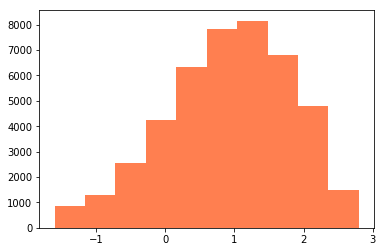

In [81]:
# Distribution of values for distance from cutoff.
print(plt.pyplot.hist(data['dist_from_cut'], color = "coral"))

In [82]:
# Reduce sample to students within 1.2 points from cutoff.
sample12 = data[abs(data['dist_from_cut']) < 1.2] 
sample12.reset_index(inplace=True)
print("A sample of students within 1.2 points from the cuttoff encompasses", sample12.shape[0], "observations.")

A sample of students within 1.2 points from the cuttoff encompasses 25389 observations.


In [83]:
# Reduce sample to students within 0.6 points from cutoff.
sample06 = data[abs(data['dist_from_cut']) < 0.6]  
sample06.reset_index(inplace=True)
print("The final sample includes", sample06.shape[0], "observations.")

The final sample includes 12530 observations.


### Table 1 – Summary Statistics

In [84]:
main = sample06[['hsgrade_pct','totcredits_year1', 'age_at_entry','male', 'english', 'bpl_north_america', 
             'loc_campus1','loc_campus2', 'loc_campus3',
             'dist_from_cut', 'probation_year1', 'probation_ever', 'left_school', 'year2_dist_from_cut',
             'suspended_ever', 'gradin4', 'gradin5', 'gradin6']]

In [85]:
table1 = pd.DataFrame()
table1['Mean'] = main.mean()
table1['Standard Deviation'] = main.std()
#table1 = table1.astype(float).round(2)
table1['Description'] = ["High School Grade Percentile", "Credits attempted first year", "Age at entry",
                         "Male", "English is first language", "Born in North America", 
                         "At Campus 1", "At Campus 2", "At Campus 3",
                         "Distance from cutoff in first year", "On probation after first year", " Ever on acad. probation",
                         "Left uni after 1st evaluation", "Distance from cutoff at next evaluation", "Ever suspended",
                         "Graduated by year  4", "Graduated by year  5", "Graduated by year  6"]
table1.loc[0:9,'Type'] = "Characteristics"
table1.loc[9:,'Type'] = "Outcomes"
table1

,Mean,Standard Deviation,Description,Type
hsgrade_pct,33.332085,23.288502,High School Grade Percentile,Characteristics
totcredits_year1,4.426975,0.530186,Credits attempted first year,Characteristics
age_at_entry,18.718756,0.735240,Age at entry,Characteristics
male,0.375180,0.484199,Male,Characteristics
english,0.718755,0.449625,English is first language,Characteristics
bpl_north_america,0.870231,0.336071,Born in North America,Characteristics
loc_campus1,0.478132,0.499548,At Campus 1,Characteristics
loc_campus2,0.209497,0.406989,At Campus 2,Characteristics
loc_campus3,0.312370,0.463482,At Campus 3,Characteristics
dist_from_cut,0.111093,0.325851,Distance from cutoff in first year,Outcomes


## Empirical Strategy

$Y_{ic} = m(GPANORM_{ic}^{year1}) + \delta1(GPANORM_{ic}^{year1}<0) + u_{ic} $


## Regression Analysis

In [86]:
# Add constant to sample to use in regressions later.
sample12['const'] = 1

C:\Users\arohanui\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Tests of the Validity of the RD Approach

One of the major concerns in the application of regression discontinuity designs is **nonrandom sorting**. In Lindo et al. (2010) such troubles could arise if students just below the cutoff were to actively influence their GPAs to avoid being put on academic probabtion. 

Lindo et al. (2010) focus on _first year students_ for this reason, as they assume this group of students is likely to be less familiar with the probation policy on campus. To verify their conjecture, the author also conducted as survey in an introductory economics course which revealed that around 50 % of students were unsure of the probation cutoff at their campus. They also claim that this analysis showed no relationship between knowledge of probation cutoffs and student's grades. 

The authors also point out that most first year courses span the entire year and most of the evaluation takes place at the end of the term which would make it difficult for students to purposely aim for performances slightly above the cutoff for academic probation. 

If nonrandom sorting were to be a problem nontheless, there should be a **discontinuity** in the distribution of grades at the cutoff with a disproportionate number of students scoring just above the cutoff. To assess the validity of applying an RDD design, we thus first check whether this is the case.

I first sort the data from sample12 (the sample containing all observations within 1.2 GPA points from the cutoff) into bins of size 0.1. The bins contain their lower limit but not their upper limit (i.e. _[lower limit ,upper limit)_): 

<span class="mark"> NOTE: To be moved to auxilary</span>

In [87]:
sample_treat = sample12[sample12['dist_from_cut'] < 0]
sample_untreat = sample12[sample12['dist_from_cut'] >= 0]

In [88]:
# Bins for treated group
bins_treat = [-1.21,-1.11,-1.01,-0.91,-0.81,-0.71,-0.61,-0.51,-0.41,-0.31,-0.21,-0.11, -0.01]
bins_labels_treat = np.arange(-1.15,0,0.1)

sample_treat['bins'] = pd.cut(x=sample_treat['dist_from_cut'],bins=bins_treat, right=False, labels= bins_labels_treat )
sample_treat['bins_range'] = pd.cut(x=sample_treat['dist_from_cut'],bins=bins_treat, right=False)

C:\Users\arohanui\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\arohanui\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [89]:
# Bins for untreated group
bins_untreat = [0.0, 0.099, 0.199, 0.299, 0.399, 0.499, 0.599, 0.699, 0.799, 0.899, 0.999, 1.099, 1.199]
bins_labels_untreat = np.arange(0.05,1.25,0.1)

sample_untreat['bins'] = pd.cut(x=sample_untreat['dist_from_cut'],bins=bins_untreat, right=False, labels= bins_labels_untreat )
sample_untreat['bins_range'] = pd.cut(x=sample_untreat['dist_from_cut'],bins=bins_untreat, right=False)

C:\Users\arohanui\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\arohanui\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [90]:
# Rejoin treated and untreated sample 
sample12 = pd.concat([sample_untreat, sample_treat])
sample12.reset_index(inplace=True)

sample12[['dist_from_cut', 'bins', 'bins_range']].head()

,dist_from_cut,bins,bins_range
0,0.45,0.45,"[0.399, 0.499)"
1,0.68,0.65,"[0.599, 0.699)"
2,0.84,0.85,"[0.799, 0.899)"
3,0.98,0.95,"[0.899, 0.999)"
4,0.80,0.85,"[0.799, 0.899)"


Plot frequency of each bin & regression line:

In [91]:
figure1 = pd.DataFrame(sample12['bins'].value_counts())
figure1.reset_index(level=0, inplace=True)
figure1.rename(columns={"index": "bins", "bins": "counts"}, inplace=True)

Text(0,0.5,'Frequency count')

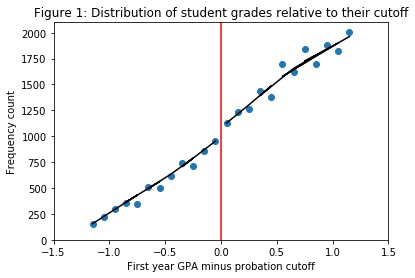

In [92]:
fig1_untreated = figure1[figure1['bins'] > 0]
fig1_treated = figure1[figure1['bins'] < 0]

lowess_treated  = sm.nonparametric.smoothers_lowess.lowess(
        endog=fig1_treated.counts, 
        exog=fig1_treated.bins, 
        return_sorted=False, 
        frac=0.7, 
        delta=0,
    )

lowess_untreated  = sm.nonparametric.smoothers_lowess.lowess(
        endog=fig1_untreated.counts, 
        exog=fig1_untreated.bins, 
        return_sorted=False, 
        frac=0.7, 
        delta=0,
    )

plt.pyplot.xlim(-1.5,1.5,0.1)
plt.pyplot.ylim(0,2100)
plt.pyplot.plot(figure1.bins,figure1.counts, 'o')
plt.pyplot.axvline(x=0, color='r')
plt.pyplot.plot(fig1_untreated.bins,lowess_untreated, "k")
plt.pyplot.plot(fig1_treated.bins,lowess_treated, "k")
plt.pyplot.title('Figure 1: Distribution of student grades relative to their cutoff')
plt.pyplot.xlabel('First year GPA minus probation cutoff')
plt.pyplot.ylabel('Frequency count')

#### Table 2 - Estimated Discontinuities in observable characteristics 

In [93]:
# Reduce sample to bandwidth of 0.6 for the next steps.
sample06 = sample12[abs(sample12['dist_from_cut']) < 0.6]  
#sample06.reset_index(inplace=True)
sample06.shape

(12530, 91)

Define funtion to hightlight values below 0.05 to apply on the p-values in the tables.

<span class="mark">NOTE: To be moved to auxilary</span>

In [94]:
def pvalue_5percent_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for values
    below 0.05, black otherwise.
    """
    color = 'red' if val < 0.05 else 'black'
    return 'color: %s' % color

In [95]:
# Define covariates and regressors.
covariates = ('hsgrade_pct','totcredits_year1', 'age_at_entry','male', 'english', 'bpl_north_america', 
              'loc_campus1','loc_campus2')
regressors = ['const','gpalscutoff','gpaXgpalscutoff','gpaXgpagrcutoff']


In [96]:
# Create shell for tables 2-4.
table_template = pd.DataFrame({ 'GPA below cutoff (1)': [], 'P-Value (1)':[], 'Std.err (1)':[], 
                       'Intercept (0)':[], 'P-Value (0)':[], 'Std.err (0)':[], 
                       'Observations':[]})

In [97]:
# Create shell for table 2. 
table2 = table_template.copy()
table2['covariates'] = covariates
table2 = table2.set_index('covariates')

In [98]:
# Regression analysis for table 2.
for covariate in covariates:
    model = sm.regression.linear_model.OLS(sample06[covariate], sample06[regressors], hasconst=True)
    result = model.fit(cov_type='cluster', cov_kwds={'groups': sample06['clustervar']})
    outputs = [result.params['gpalscutoff'], result.pvalues['gpalscutoff'], result.bse['gpalscutoff'], 
               result.params['const'], result.pvalues['const'], result.bse['const'], 
               len(sample06[covariate])]   
    table2.loc[covariate] = outputs

table2 = table2.round(3)

In [99]:
# Mark significant p-values (at 5% level) red & display table.
table2.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
covariates,,,,,,,
hsgrade_pct,0.45,0.72,1.259,30.991,0,0.745,12530
totcredits_year1,0.024,0.749,0.076,4.386,0,0.046,12530
age_at_entry,0.015,0.641,0.032,18.719,0,0.021,12530
male,0,0.989,0.024,0.374,0,0.012,12530
english,-0.037,0.124,0.024,0.729,0,0.015,12530
bpl_north_america,0.017,0.173,0.013,0.864,0,0.008,12530
loc_campus1,0.012,0.724,0.034,0.444,0,0.022,12530
loc_campus2,-0.01,0.719,0.027,0.217,0,0.018,12530


### First year GPAs and Academic Probation

#### Figure 2 - Porbation Status at the End of First Year

Text(0,0.5,'Probation Status')

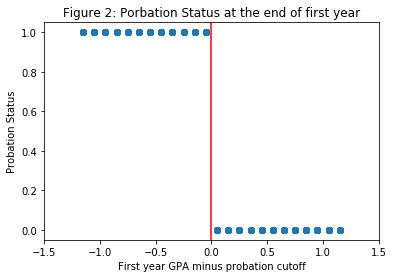

In [100]:
plt.pyplot.xlim(-1.5,1.5,0.1)
plt.pyplot.plot(sample12['bins'], sample12['gpalscutoff'], 'o')
plt.pyplot.axvline(x=0, color='r')
plt.pyplot.title('Figure 2: Porbation Status at the end of first year')
plt.pyplot.xlabel('First year GPA minus probation cutoff')
plt.pyplot.ylabel('Probation Status')

#### Table 3 - Estimated Discontinuity in Probabtion Status

Table 3 shows the estimated discontinuity in probation status after the first year (_part 1_) and for ever being placed on academic probation (_part 2_). 

To estimate the discontunuity in probation status, the authors again use a bandwidth of 0.6 from the cutoff. In addition to the whole sample this condition applies to, they also estimate the discontinuities for certain subgroups in the sample:

* **high school grades below** and **above the median** (here, median refers to the median of the entire dataset (median: _50_) and not the median of the subset of students with a GPA within 0.6 grade points of teh probation cutoff (the median for this set would be _28_))
* **male** and **female** students
* **english** native speakers and students with a different native language (**nonenglish**) 

In [101]:
# Create groups and save them to a dictionary.
groups_labels = ['All', 'HS Grades < median', 'HS Grades > median', 'Male', 'Female', 'Native English', 'Nonnative English']

hsgrade_pct_low = sample06[sample06['lowHS'] == 1] 
hsgrade_pct_high = sample06[sample06['highHS'] == 1] 
male = sample06[sample06['male'] == 1] 
female = sample06[sample06['female'] == 1] 
english = sample06[sample06['english'] == 1]
noenglish = sample06[sample06['noenglish'] == 1]

groups_dict = {'All': sample06, 'HS Grades < median': hsgrade_pct_low, 'HS Grades > median': hsgrade_pct_high, 
               'Male': male, 'Female': female, 'Native English': english, 'Nonnative English': noenglish
              }

In [102]:
# Create shell for table 3.
table3 = table_template.copy()
table3['groups'] = groups_labels
table3 = table3.set_index('groups')

**Table 3 | Part 1 - Estimated Discontinuity in Probabtion Status for Year 1**

In [104]:
# Run regression and fill in values for table 3_1.
table3_1 = table3.copy()

for group in groups_labels:
    model = sm.regression.linear_model.OLS(groups_dict[group]['probation_year1'], groups_dict[group][regressors], hasconst=True) 
    result = model.fit(cov_type='cluster', cov_kwds={'groups': groups_dict[group]['clustervar']})
    outputs = [result.params['gpalscutoff'], result.pvalues['gpalscutoff'], result.bse['gpalscutoff'], 
               result.params['const'], result.pvalues['const'], result.bse['const'], 
               len(groups_dict[group]['probation_year1'])]   
    table3_1.loc[group] = outputs
    
table3_1 = table3_1.round(3)
table3_1.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,0.994,0,0.002,0.001,0.157,0.001,12530
HS Grades < median,0.995,0,0.002,0.001,0.183,0.001,9473
HS Grades > median,0.99,0,0.006,0.001,0.317,0.001,3057
Male,0.99,0,0.005,0.001,0.319,0.001,4701
Female,0.996,0,0.002,0.001,0.179,0.001,7829
Native English,0.993,0,0.002,0.001,0.16,0.001,9006
Nonnative English,0.997,0,0.003,0,0,0,3524


**Table 3 | Part 2 - Estimated Discontinuity in Probabtion Status Ever**

In [106]:
table3_2 = table3.copy()

for group in groups_labels:
    model = sm.regression.linear_model.OLS(groups_dict[group]['probation_ever'], groups_dict[group][regressors], hasconst=True)
    result = model.fit(cov_type='cluster', cov_kwds={'groups': groups_dict[group]['clustervar']})
    outputs = [result.params['gpalscutoff'], result.pvalues['gpalscutoff'], result.bse['gpalscutoff'], 
               result.params['const'], result.pvalues['const'], result.bse['const'], 
               len(groups_dict[group]['probation_ever'])]   
    table3_2.loc[group] = outputs
    
table3_2 = table3_2.round(3)
table3_2.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,0.665,0,0.014,0.33,0,0.014,12530
HS Grades < median,0.653,0,0.014,0.343,0,0.014,9473
HS Grades > median,0.705,0,0.023,0.286,0,0.022,3057
Male,0.625,0,0.016,0.366,0,0.015,4701
Female,0.69,0,0.017,0.308,0,0.017,7829
Native English,0.677,0,0.016,0.317,0,0.016,9006
Nonnative English,0.635,0,0.023,0.362,0,0.022,3524


### The Immediate Response to Academic Probation 

#### Table 4 - Estimated Effect on the Decision to Leave after the First Evaluation

In [109]:
table4 = table_template.copy()
table4['groups'] = groups_labels
table4 = table4.set_index('groups')

In [110]:
for group in groups_labels:
    model = sm.regression.linear_model.OLS(groups_dict[group]['left_school'], groups_dict[group][regressors], hasconst=True)
    result = model.fit(cov_type='cluster', cov_kwds={'groups': groups_dict[group]['clustervar']})
    outputs = [result.params['gpalscutoff'], result.pvalues['gpalscutoff'], result.bse['gpalscutoff'], 
               result.params['const'], result.pvalues['const'], result.bse['const'], 
               len(groups_dict[group]['left_school'])]   
    table4.loc[group] = outputs
    
table4 = table4.round(3)
table4.style.applymap(pvalue_5percent_red, subset=['P-Value (1)', 'P-Value (0)'])

,GPA below cutoff (1),P-Value (1),Std.err (1),Intercept (0),P-Value (0),Std.err (0),Observations
groups,,,,,,,
All,0.018,0.01,0.007,0.041,0,0.004,12530
HS Grades < median,0.013,0.107,0.008,0.045,0,0.005,9473
HS Grades > median,0.032,0.058,0.017,0.026,0,0.007,3057
Male,0.037,0.014,0.015,0.038,0,0.007,4701
Female,0.006,0.53,0.009,0.043,0,0.004,7829
Native English,0.028,0.003,0.01,0.047,0,0.005,9006
Nonnative English,-0.004,0.713,0.011,0.025,0,0.007,3524


#### Figure 3

# Miscellaneous

In [67]:
"""# Alternative for table 2
table22 = pd.DataFrame({'outputs': ['GPA below cutoff', 'P-Value GPA below cutoff', 'Intercept', 'P-Value Intercept', 'Observations']})
table22 = table22.set_index('outputs')

for covariate in covariates:
    
    result = sm.regression.linear_model.OLS(sample06[covariate], regressors, hasconst=True).fit()
    outputs = [result.params[1], result.pvalues[1], result.params[0], result.pvalues[0], len(sample06[covariate])]   
    table22[covariate] = outputs

table22=table22.round(4)"""

"# Alternative for table 2\ntable22 = pd.DataFrame({'outputs': ['GPA below cutoff', 'P-Value GPA below cutoff', 'Intercept', 'P-Value Intercept', 'Observations']})\ntable22 = table22.set_index('outputs')\n\nfor covariate in covariates:\n    \n    result = sm.regression.linear_model.OLS(sample06[covariate], regressors, hasconst=True).fit()\n    outputs = [result.params[1], result.pvalues[1], result.params[0], result.pvalues[0], len(sample06[covariate])]   \n    table22[covariate] = outputs\n\ntable22=table22.round(4)"